# Analysis of NIBRS data

This notebook analyzes data from the FBI's National Incident-Based Reporting System. Please see this repository's `README.md` file for more context.

# Import Python libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys

from utils import (
    percentify_axes,
    plot_rates,
    make_histogram_grid,
    load_nibrs_metadata_2016,
    load_nibrs_victims,
    tee,
    save,
)

# Load standardized victim data

Here, we load a dataset that we've extracted and standardized from the raw NIBRS files. Each row represents a victim, but also contains information related to the broader incident (which can have multiple victims).

In [2]:
agency_metadata = load_nibrs_metadata_2016()

In [3]:
victims_all = load_nibrs_victims()

victims_all.head()

,victim_uid,top_offense_code,incident_uid,victim_injury_category,domestic_violence_ind,family_violence_ind,victim_age,victim_sex,victim_race,victim_ethnicity,...,arrest_date,exc_clearance_ind,exc_clearance_date,clearance_ind,victim_count,ori_group_report,larger_city_report,ori_group_2016,larger_city_2016,state
0,VA0370000|1996|Z63BRW5HPU72-001,09A,VA0370000|1996|Z63BRW5HPU72,major,0,1,48,F,B,N,...,1996-06-21,0,NaN,1,3,9C,False,9C,False,VA
1,VA1230000|2015|94-4NLE8O39G-001,09A,VA1230000|2015|94-4NLE8O39G,missing,0,0,21,M,B,N,...,NaT,0,NaN,0,3,3,False,3,False,VA
2,OHCOP0000|2010|8I0VYC5VT2 N-001,09A,OHCOP0000|2010|8I0VYC5VT2 N,missing,0,0,15,M,B,NaN,...,NaT,0,NaN,0,1,1B,True,1B,True,OH
3,CT0004300|2012|2W1J0U73LNK-001,09A,CT0004300|2012|2W1J0U73LNK,major,1,0,28,F,W,N,...,2012-05-19,0,NaN,1,2,3,False,3,False,CT
4,VA1230000|2015|7I-IMIR6ZU72-001,09A,VA1230000|2015|7I-IMIR6ZU72,missing,0,0,24,M,B,N,...,2015-05-18,0,NaN,1,4,3,False,3,False,VA


In [4]:
victims_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6365760 entries, 0 to 6365759
Data columns (total 31 columns):
victim_uid                 object
top_offense_code           object
incident_uid               object
victim_injury_category     object
domestic_violence_ind      int64
family_violence_ind        int64
victim_age                 object
victim_sex                 object
victim_race                object
victim_ethnicity           object
circumstance_1             float64
circumstance_2             float64
victim_officer_ind         int64
primary_weapon_category    object
firearm_ind                int64
location_home_ind          int64
agency_ori_9               object
occurred_date              datetime64[ns]
year                       int64
month                      int64
arrest_ind                 int64
arrest_date                datetime64[ns]
exc_clearance_ind          int64
exc_clearance_date         float64
clearance_ind              int64
victim_count               i

Agencies reporting the most victims, and states whose agencies have reported the most victims:

In [5]:
victims_all["agency_ori_9"].value_counts().head()

# In order:
# 
# Detroit PD
# Memphis PD
# Metropolitan Nashville PD
# Milwaukee PD
# Cleveland PD

MI8234900    212298
TNMPD0000    209768
TN0190100    152569
WIMPD0000    103442
OHCLP0000     83917
Name: agency_ori_9, dtype: int64

In [6]:
victims_all["state"] = victims_all["agency_ori_9"].str.slice(0, 2)
victims_all["state"].value_counts().head()

MI    929987
SC    913055
TN    808882
OH    431619
VA    428057
Name: state, dtype: int64

Here are the number of of __victims__ for each of the top offense codes:

In [7]:
victims_all["top_offense_code"].value_counts().sort_index()

09A      60691
09B       3849
09C       2170
11A     489342
11B     116372
11C      55879
11D     574608
120    1364909
13A    3697940
Name: top_offense_code, dtype: int64

## Create two new race/ethnicity variables

- `victim_race_h`: Here, Hispanic ethnicity takes precedence over race, an often used in the analysis of Census data.

- `victim_race_condensed`: Here, victim race and ethnicity are condensed further, into three categories: `Black/Hispanic`, `White`, and `Other` (which includes victims of other races, and victims for which race/ethnicity was listed as unknown).

In [8]:
victims_all["victim_race"].value_counts()

W    3985916
B    2090088
U     190343
A      60381
I      38629
P        403
Name: victim_race, dtype: int64

In [9]:
victims_all["victim_race_h"] = (
    victims_all
    ["victim_ethnicity"]
    .replace({ "U": None, "N": None })
    .astype(object)
    .fillna(victims_all["victim_race"])
)
    
victims_all["victim_race_h"].value_counts()

W    3565197
B    2078233
H     454988
U     170903
A      59047
I      37095
P        297
Name: victim_race_h, dtype: int64

In [10]:
victims_all["victim_race_condensed"] = (
    victims_all
    ["victim_race_h"]
    .apply({
        "B": "Black/Hispanic",
        "H": "Black/Hispanic",
        "W": "White",
    }.get)
    .fillna("Other")
)
    
victims_all["victim_race_condensed"].value_counts()

White             3565197
Black/Hispanic    2533221
Other              267342
Name: victim_race_condensed, dtype: int64

## Add a calculation of the number of days between the incident and an arrest

In [11]:
victims_all["days_to_arrest"] = (victims_all["arrest_date"] - victims_all["occurred_date"]).dt.days

## Identify (small number of) agencies that appear not to update arrest information after 100 days (or sooner)

A small number of larger-city agencies appear not to have updated their NIBRS arrest data for arrests that occurred more than 100 days after the incident. Below, we identify them, so that we can later remove them.

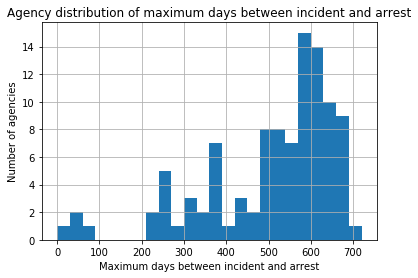

In [12]:
ax = (
    victims_all
    .loc[lambda df: df["year"] >= 2000]
    .loc[lambda df: df["larger_city_2016"] == True]
    .groupby([ "agency_ori_9" ])
    ["days_to_arrest"]
    .max()
    .pipe(lambda x: x.hist(
        bins = range(0, int(x.max()) + 30, 30),
    ))
)
ax.set_title("Agency distribution of maximum days between incident and arrest")
ax.set_xlabel("Maximum days between incident and arrest")
ax.set_ylabel("Number of agencies")
pass

In [13]:
early_nonupdaters = (
    victims_all
    .loc[lambda df: df["year"] >= 2000]
    .loc[lambda df: df["larger_city_2016"] == True]
    .groupby([ "agency_ori_9" ])
    .pipe(lambda grp: pd.DataFrame({
        "days_to_arrest_max": grp["days_to_arrest"].max(),
        "num_incidents": grp.size()
    }))
    .loc[lambda df: df["days_to_arrest_max"] <= 100]
    .sort_values("days_to_arrest_max")
)

early_nonupdaters

,days_to_arrest_max,num_incidents
agency_ori_9,,
WA0320400,17.0,445
TX2200100,33.0,28
MA0091100,50.0,4037
OK0140200,87.0,400


# Select core subset of victims

... to contain only incidents that:

- Occurred in the year 2000 or later
- Were reported to a larger-city agency
- Were not reported one of the four agencies identified above as possibly not updating arrest information after a certain number of days have elapsed

In [14]:
victims = (
    victims_all
    .loc[lambda df: df["year"] >= 2000]
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: ~df["agency_ori_9"].isin(early_nonupdaters.index)]
)

len(victims)

2160423

In [15]:
assert "WA0320400" not in victims["agency_ori_9"].values

# Select firearm assault victims

Here, we select only victims for whom aggravated assault was the top offense and were attacked with a firearm:

In [16]:
firearm_assault_victims_init = (
    victims
    .loc[lambda df: df["top_offense_code"] == "13A"]
    .loc[lambda df: df["firearm_ind"] == 1]
    .assign(
        # Convert injury category to an ordinal variable,
        # so that we can identify the most serious injury category
        # for each incident.
        injury_ranking = lambda df: df["victim_injury_category"].apply({
            "major": 0,
            "minor": 1,
            "none": 2
        }.get)
    )    
)

firearm_assault_victims_init.head()

,victim_uid,top_offense_code,incident_uid,victim_injury_category,domestic_violence_ind,family_violence_ind,victim_age,victim_sex,victim_race,victim_ethnicity,...,victim_count,ori_group_report,larger_city_report,ori_group_2016,larger_city_2016,state,victim_race_h,victim_race_condensed,days_to_arrest,injury_ranking
2667824,SC0400100|2011|8N0BRFQ-Q2 N-002,13A,SC0400100|2011|8N0BRFQ-Q2 N,major,0,0,50,M,B,N,...,4,2,True,2,True,SC,B,Black/Hispanic,NaN,0
2667837,MI8234900|2011|1A1M0H7Z8N08-001,13A,MI8234900|2011|1A1M0H7Z8N08,minor,0,0,26,F,B,U,...,1,1B,True,1B,True,MI,B,Black/Hispanic,NaN,1
2667839,MI8234900|2011|1A1M0-FU87 W-001,13A,MI8234900|2011|1A1M0-FU87 W,minor,0,0,25,M,B,U,...,3,1B,True,1B,True,MI,B,Black/Hispanic,0.0,1
2667840,MI8234900|2011|1A1M0H7Z86J-001,13A,MI8234900|2011|1A1M0H7Z86J,none,0,0,45,M,B,U,...,1,1B,True,1B,True,MI,B,Black/Hispanic,NaN,2
2667842,MI8234900|2011|1A1M04FZ8N N-001,13A,MI8234900|2011|1A1M04FZ8N N,none,0,0,62,M,B,U,...,1,1B,True,1B,True,MI,B,Black/Hispanic,NaN,2


A small proportion of victims — about 0.6% — are law enforcement officers; in the analyses below, we exclude their incidents, because they are likely to be investigated in a substantially different manner than other incidents.

In [17]:
(
    firearm_assault_victims_init
    ["victim_officer_ind"]
    .value_counts(normalize = True)
)

0    0.993641
1    0.006359
Name: victim_officer_ind, dtype: float64

In [18]:
officer_incident_uids = (
    victims
    .loc[lambda df: df["victim_officer_ind"] == 1]
    ["incident_uid"]
    .unique()
)

In [19]:
firearm_assault_victims = (
    firearm_assault_victims_init
    .loc[lambda df: ~df["incident_uid"].isin(officer_incident_uids)]
    .copy()
)

In [20]:
len(firearm_assault_victims), len(firearm_assault_victims_init)

(353597, 356191)

# Examine firearm assaults, by injury

The NIBRS data defines several types of injuries, which we have grouped into three larger categories:

__Major injuries__

- "Unconsciousness" (code `U`)
- "Severe Laceration" (code `L`)
- "Possible Internal Injury" (code `I`)
- "Apparent Broken Bones" (code `B`)
- "Loss of Teeth" (code `T`)
- "Other Major Injury" (code `O`)

__Minor injuries__

- "Apparent Minor Injury" (code `M`)

__No injury__

- "None" (code `N`)
- [Note: Below, this category also includes victims for which no injury codes have been listed]

## Examine likely-missing injury data

Some agencies (for some years) appear not to report any injuries among their firearm assault victims. Below, we identify those agency-years, and calculate their prevalence.

Here, we tabulate the number of victims, by injury type, for each agency-year:

In [21]:
ori_fa_injury_counts = (
    
    firearm_assault_victims    
    .groupby([
        "agency_ori_9",
        "year",
        "victim_injury_category",
    ])
    
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
    
    .assign(total_victims = lambda x: x.sum(axis = 1))
    
    .assign(injured_victims = lambda x: x[[ "major", "minor" ]].sum(axis = 1))
    
    .reset_index()
    
    .rename_axis(None, "columns")
)

ori_fa_injury_counts.head()

,agency_ori_9,year,major,minor,none,total_victims,injured_victims
0,AR0600200,2002,0,0,1,1,0
1,AR0600200,2008,7,4,42,53,11
2,AR0600200,2009,83,97,624,804,180
3,AR0600200,2010,74,85,696,855,159
4,AR0600200,2011,78,98,735,911,176


Some agencies have, in certain years, reported 10+ firearm assault victims but none with injuries:

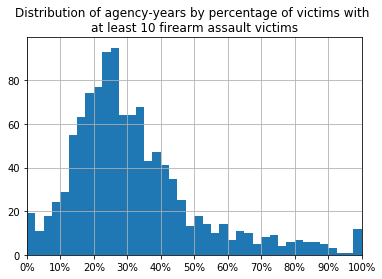

In [22]:
ax = (
    ori_fa_injury_counts
    .loc[lambda df: df["total_victims"] >= 10]
    .assign(
        injury_rate = lambda df: df["injured_victims"] / df["total_victims"]
    )
    ["injury_rate"]
    .clip(0, 0.99999)
    .hist(
        bins = pd.np.arange(0, 1.1, 0.025),
    )
)
ax.set_title(
    "Distribution of agency-years by percentage of victims with \n"
    "at least 10 firearm assault victims"
)
percentify_axes(ax, name = "x")
pass

In all, about 2% of agency-years report no victim injuries, among agency-years with at least 10 firearm assault victims. The rate is lower when you raise the total-victim victim threshold — and among larger-city agency-years with at least 100 firearm assault victims, all include at least one injury.

In [23]:
for n in [ 10, 50, 100 ]:
    (
        ori_fa_injury_counts
        .loc[lambda df: df["total_victims"] >= n]
        .assign(
            zero_injured = lambda df: df["injured_victims"] == 0,
        )
        .pipe(lambda x: print(
            f"{n}+ victims: {x['zero_injured'].mean() * 100:.1f}% "
            f"({x['zero_injured'].sum()} of {len(x):,})")
        )
    )

10+ victims: 1.7% (19 of 1,115)
50+ victims: 0.9% (7 of 793)
100+ victims: 0.0% (0 of 580)


The proportion of no-injury agency-years, among agency-years with 10+ firearm assault victim, has been roughly steady since at least 2000:

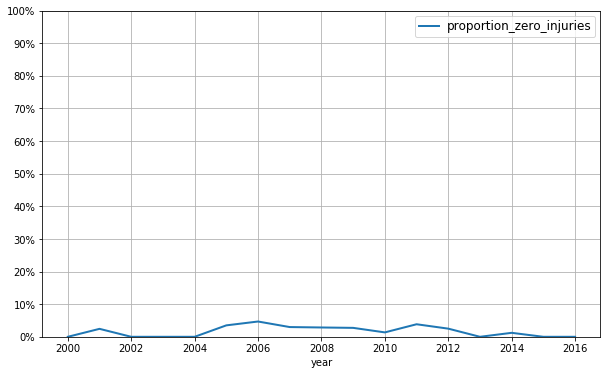

In [24]:
(
    ori_fa_injury_counts
    .loc[lambda df: df["total_victims"] >= 10]
    .assign(
        no_injuries = lambda df: df["injured_victims"] == 0
    )
    .groupby("year")
    ["no_injuries"].mean()
    .to_frame("proportion_zero_injuries")
    .pipe(plot_rates, ylim = (0, 0.1))
);

## Examine concentration of victims among larger-city agencies, for murder and aggravated assault, 2007–16

There is a substantial level of concentration of victims, most drastically among firearm murders, where Detroit PD accounts for nearly 22% of all victims. (The agency accounts for 14% of non-firearm murders, and also 14% of firearm assaults.)

In [25]:
(
    victims
    .loc[lambda df: df["year"] >= 2007]
    .loc[lambda df: df["top_offense_code"].isin([ "09A", "13A" ])]
    .groupby([
        "top_offense_code",
        "firearm_ind"
    ])
    .apply(lambda grp: (
        grp["agency_ori_9"].value_counts(normalize = True).head(5)
    ))
    .to_frame("prop")
    .round(3)
)

prop
top_offense_code firearm_ind                 
09A              0           MI8234900  0.140
                             TNMPD0000  0.097
                             OHCLP0000  0.076
                             WIMPD0000  0.047
                             OHCOP0000  0.042
                 1           MI8234900  0.215
                             TNMPD0000  0.071
                             WIMPD0000  0.063
                             OHCOP0000  0.054
                             MOKPD0000  0.049
13A              0           MI8234900  0.122
                             TNMPD0000  0.083
                             TN0190100  0.067
                             WIMPD0000  0.044
                             TX2201200  0.033
                 1           MI8234900  0.143
                             TNMPD0000  0.119
                             WIMPD0000  0.076
                             TN0190100  0.060
                             MOKPD0000  0.060

# Aggregate victims into incident-level data

A single incident can involve multiple offenses (even for a single victim); the code below identifies the highest-ranked incident (according to the FBI Uniform Crime Report's offense hierarchy, with murder — `09A` — as the most serious) for each incident.

Here we identify the __incident-level__ top offense codes:

In [26]:
incident_top_offense_codes = (
    victims
    .sort_values("top_offense_code")
    .drop_duplicates(subset = [ "incident_uid" ])
    [[
        "incident_uid",
        "top_offense_code"
    ]]
)

incident_top_offense_codes.head()

,incident_uid,top_offense_code
2,OHCOP0000|2010|8I0VYC5VT2 N,09A
40562,OHCOP0000|2008|D0AAASCV2 N,09A
40557,CODPD0000|2005|2J-J4542VF39,09A
40551,TX1880100|2011|2W1M02HP946A,09A
40547,TX1880100|2011|2W1M02F2J6JA,09A


In [27]:
incident_top_offense_codes["top_offense_code"].value_counts().sort_index()

09A     22804
09B       455
09C      1106
11A    124249
11B     25693
11C     12309
11D    113231
120    595136
13A    907737
Name: top_offense_code, dtype: int64

Here, we identify all incidents in which a firearm assault was the top offense:

In [28]:
firearm_assault_incidents = (
    firearm_assault_victims
    [[
        "year",
        "incident_uid",
        "agency_ori_9",
        "ori_group_2016",
        "victim_injury_category",
        "injury_ranking",
        "occurred_date",
        "arrest_ind",
        "arrest_date",
    ]]
    
    # Choose only incidents where aggravated assault
    # is the top offense
    .merge(
        incident_top_offense_codes
        .loc[lambda df: df["top_offense_code"] == "13A"],
        how = "inner",
        on = [ "incident_uid" ]        
    )
    .sort_values("injury_ranking")    
    .drop_duplicates(subset = [ "incident_uid" ])
    .rename(columns = {
        "victim_injury_category": "injury_category"
    })
    .drop(columns = [ "top_offense_code" ])
)

len(firearm_assault_incidents)

244253

In [29]:
firearm_assault_incidents.head()

,year,incident_uid,agency_ori_9,ori_group_2016,injury_category,injury_ranking,occurred_date,arrest_ind,arrest_date
85770,2013,TN0190100|2013|2W100KZLZ62A,TN0190100,1B,major,0,2013-03-26,0,NaT
148547,2015,TN0750100|2015|M-MQ-K1T2 I,TN0750100,2,major,0,2015-03-28,0,NaT
148546,2015,TN0750100|2015|94-4KH48ZX9G,TN0750100,2,major,0,2015-07-12,1,2015-07-12
43205,2016,VA1170000|2016|1X0NPBOP660W,VA1170000,2,major,0,2016-07-06,0,NaT
43206,2011,TN0190100|2011|2W1M0OXOZ6TA,TN0190100,1B,major,0,2011-10-28,0,NaT


# Calculate incident arrest rates by injury level

In [30]:
def format_injury_table(df):
    for col in df.columns:
        if "#" in col:
            df[col] = df[col].apply("{:,}".format)
        elif "%" in col or "Rate" in col:
            df[col] = (df[col] * 100).apply("{:.0f}%".format)
    df.index = [ x[0].upper() + x[1:] for x in df.index ]
    df.index.name = "Inj. Category"
    return df.loc[["Major", "Minor", "None"]]
    
def make_injury_table(df):
    series = df["injury_category"]
    xt = pd.DataFrame({
        "# Agencies": df["agency_ori_9"].nunique(),
        "# Incidents": series.value_counts(),
        "% Incidents": series.value_counts(normalize = True),
        "Arrest Rate": df.groupby("injury_category")["arrest_ind"].mean()
    })
    return xt

Arrest rates by injury category since 2000, for all larger-city agencies:

In [31]:
(
    firearm_assault_incidents
    .loc[lambda df: df["year"] >= 2000]
    .pipe(make_injury_table)
    .pipe(format_injury_table)
)

,# Agencies,# Incidents,% Incidents,Arrest Rate
Inj. Category,,,,
Major,98,"54,289",22%,22%
Minor,98,"39,596",16%,26%
None,98,"150,368",62%,25%


Note: Incidents are classified by the most serious injury sustained by a firearm assault victim. (In the case of an incident in which one victim sustained a major injury and another sustained a minor injury, the incident's overall injury category would be classified as "major".)

Excluding agency-years with no victim injuries:

In [32]:
(
    firearm_assault_incidents
    .loc[lambda df: df["year"] >= 2000]
    
    .merge(
        ori_fa_injury_counts,
        how = "left",
        on = [ "agency_ori_9", "year" ]
    )
    
    .loc[lambda df: df["injured_victims"] > 0]
    .pipe(make_injury_table)
    .pipe(save, "../../outputs/nibrs-firearm-assault-arrest-rates-larger-city.csv", index = True)
    .pipe(format_injury_table)
)

,# Agencies,# Incidents,% Incidents,Arrest Rate
Inj. Category,,,,
Major,98,"54,289",22%,22%
Minor,98,"39,596",16%,26%
None,98,"149,813",61%,24%


Charting the same universe as the table above, but over time, for injury proportions...

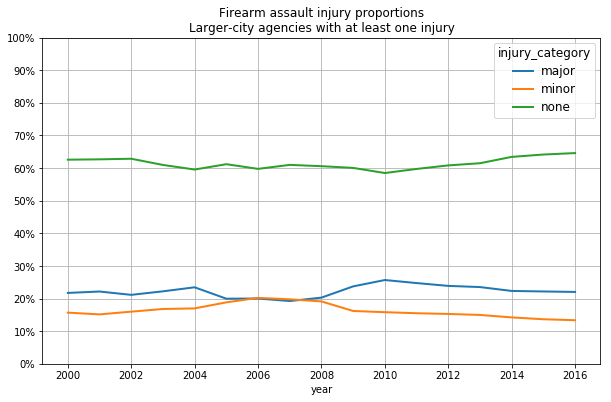

In [33]:
(
    firearm_assault_incidents
    .loc[lambda df: df["year"] >= 2000]
    
    .merge(
        ori_fa_injury_counts,
        how = "left",
        on = [ "agency_ori_9", "year" ]
    )
    
    .loc[lambda df: df["injured_victims"] > 0]
    .groupby([
        "year",
    ])
    ["injury_category"]
    .value_counts(normalize = True)
    .unstack()
    .pipe(
        plot_rates,
        title = (
            "Firearm assault injury proportions\n"
            "Larger-city agencies with at least one injury"
        )
    )
)
pass

... and for arrest rates:

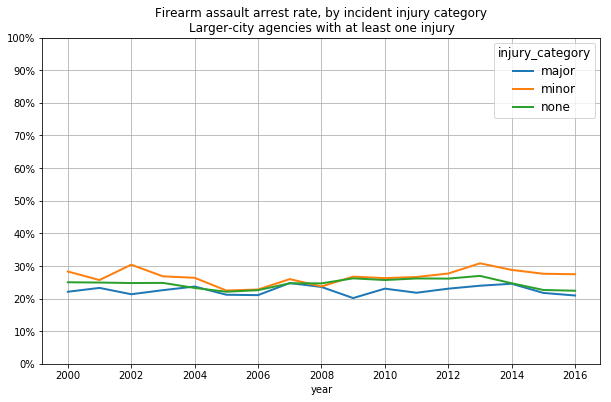

In [34]:
(
    firearm_assault_incidents
    .loc[lambda df: df["year"] >= 2000]
    
    .merge(
        ori_fa_injury_counts,
        how = "left",
        on = [ "agency_ori_9", "year" ]
    )
    
    .loc[lambda df: df["injured_victims"] > 0]
    .groupby([
        "year",
        "injury_category",
    ])
    ["arrest_ind"]
    .mean()
    .unstack()
    .pipe(
        plot_rates,
        title = (
            "Firearm assault arrest rate, by incident injury category\n"
            "Larger-city agencies with at least one injury"
        )
    )
)
pass

# Distribution of arrest rates for major/minor/no injuries, by agency

The tables and charts in the section above reflect the *aggregate* arrest rates, which combine all agencies together. To get a sense of the variance among agencies, we plot the distribution of those rates.

In [35]:
ori_rates_by_inj = (
    firearm_assault_incidents
    .loc[lambda df: df["year"] >= 2000]
    
    .merge(
        ori_fa_injury_counts,
        how = "left",
        on = [ "agency_ori_9", "year" ]
    )
    
    .loc[lambda df: df["injured_victims"] > 0]
    
    .groupby([ "agency_ori_9" ])
    
    .pipe(lambda grp: pd.DataFrame({
        "# Incidents": grp.apply(lambda x: x.groupby("injury_category").size()),
        "% Incidents": grp["injury_category"].value_counts(normalize = True),
        "Arrest Rate": grp.apply(lambda x: x.groupby("injury_category")["arrest_ind"].mean()),
    }))
    
    .reset_index()
)

ori_rates_by_inj.head()

,agency_ori_9,injury_category,# Incidents,% Incidents,Arrest Rate
0,AR0600200,major,585,0.127229,0.147009
1,AR0600200,minor,669,0.145498,0.113602
2,AR0600200,none,3344,0.727273,0.084928
3,AZ0071100,major,11,0.059140,0.545455
4,AZ0071100,minor,20,0.107527,0.500000


In [36]:
(
    ori_rates_by_inj
    .groupby("injury_category")
    ["# Incidents"]
    .describe()
    .T
)

injury_category,major,minor,none
count,98.000000,95.00000,98.000000
mean,553.969388,416.80000,1528.704082
std,1153.699406,1024.70941,3469.013604
min,1.000000,3.00000,3.000000
25%,22.500000,31.50000,145.750000
50%,96.500000,126.00000,419.000000
75%,544.000000,368.00000,1391.500000
max,7996.000000,8191.00000,22280.000000


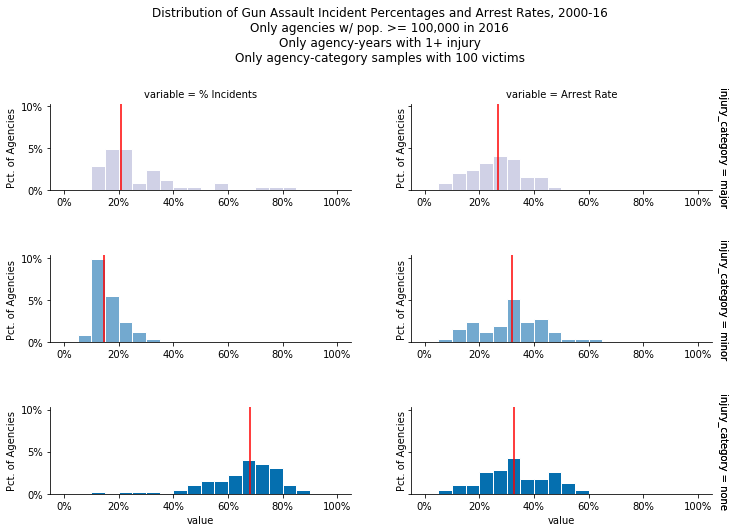

In [37]:
(
    ori_rates_by_inj
    .loc[lambda df: df["# Incidents"] >= 100]
    .drop(columns = [ "# Incidents" ])
    .melt(
        id_vars = [ "agency_ori_9", "injury_category" ]
    )
    .pipe(
        make_histogram_grid,
        row = "injury_category",
        hue = "injury_category",
        col = "variable",
        value = "value",
        title = (
            "Distribution of Gun Assault Incident Percentages and Arrest Rates, 2000-16\n"
            "Only agencies w/ pop. >= 100,000 in 2016\n"
            "Only agency-years with 1+ injury\n"
            "Only agency-category samples with 100 victims"
        )
    )
)

pass

# Examine racial disparities in arrest and clearance rates

In the sections below, we calculate the disparities in arrest and clearance rates for black/Hispanic victims vs. all other victims. In the first main section, we calculate __aggregate__ disparities, in which victims in all larger-city agencies are analyzed together. In the second section, we calculate __median__ disparities, in which disparities are first calculated at the agency level.

### Caculate the number of victims, and those whose incidents led to an arrest or clearance ...

... for each combination of agency, year, injury category, and race/ethnicity.

In [38]:
fa_counts_by_injury_and_race = (
    firearm_assault_victims
    
    .groupby([
        "year",
        "agency_ori_9",
        "ori_group_2016",
        "victim_injury_category",
        "victim_race_condensed",
    ])
    .pipe(lambda grp: pd.DataFrame({
        "victims": grp.size(),
        "victims_with_arrest": grp["arrest_ind"].sum(),
        "victims_with_clearance": grp["clearance_ind"].sum(),
    }))
    .reset_index()
)

fa_counts_by_injury_and_race.head()

,year,agency_ori_9,ori_group_2016,victim_injury_category,victim_race_condensed,victims,victims_with_arrest,victims_with_clearance
0,2000,CO0010100,1C,major,Black/Hispanic,25,12,12
1,2000,CO0010100,1C,major,Other,1,0,0
2,2000,CO0010100,1C,major,White,5,0,0
3,2000,CO0010100,1C,minor,Black/Hispanic,17,8,8
4,2000,CO0010100,1C,minor,White,5,1,1


## Caculate aggregate disparities

In [39]:
def calculate_aggregate_disparity(df, grouping):
    grouping = grouping if type(grouping) is list else [ grouping ]
    return (
        df
        .groupby(grouping + [ "victim_race_condensed" ])
        .pipe(lambda grp: pd.DataFrame({
            "num_agencies": grp["agency_ori_9"].nunique(),            
            "num_victims": grp["victims"].sum(),
            "arrest_rate": grp["victims_with_arrest"].sum() / grp["victims"].sum(),
            "clearance_rate": grp["victims_with_clearance"].sum() / grp["victims"].sum(),
        }))
        .unstack()
        .assign(
            arrest_diff = lambda df: (
                df[("arrest_rate", "White")] - 
                df[("arrest_rate", "Black/Hispanic")]
            ).round(3),
            clearance_diff = lambda df: (
                df[("clearance_rate", "White")] - 
                df[("clearance_rate", "Black/Hispanic")]
            ).round(3),
        )
    )

By injury category, 2012-2016:

In [40]:
(
    fa_counts_by_injury_and_race
    .loc[lambda df: df["year"] >= 2012]
    .loc[lambda df: df["year"] <= 2016]
    .pipe(
        calculate_aggregate_disparity,
        grouping = "victim_injury_category",
    )
    .pipe(save, "../../outputs/nibrs-fa-disparities-2012-16-injury-aggregate.csv", index = True)
)

num_agencies                num_victims               \
victim_race_condensed  Black/Hispanic Other White Black/Hispanic Other  White   
victim_injury_category                                                          
major                              88    67    89          21053   537   3341   
minor                              89    61    90          11957   370   3350   
none                               91    85    91          73634  3399  23615   

                          arrest_rate                     clearance_rate  \
victim_race_condensed  Black/Hispanic     Other     White Black/Hispanic   
victim_injury_category                                                     
major                        0.223009  0.262570  0.356779       0.250796   
minor                        0.256168  0.313514  0.379403       0.302250   
none                         0.224462  0.293322  0.308279       0.275892   

                                           arrest_diff clearance_diff  
victim_race_condensed      Other     White                             
victim_injury_category                                                 
major                   0.290503  0.406764       0.134          0.156  
minor                   0.348649  0.450149       0.123          0.148  
none                    0.328332  0.375143       0.084          0.099

In [41]:
# Simplified version, for methodology write-up
(
    fa_counts_by_injury_and_race
    .loc[lambda df: df["year"] >= 2012]
    .loc[lambda df: df["year"] <= 2016]
    .loc[lambda df: df["victim_race_condensed"].isin([
        "Black/Hispanic",
        "White",
    ])]
    .pipe(
        calculate_aggregate_disparity,
        grouping = "victim_injury_category",
    )
    [[
        "num_victims",
        "arrest_rate",
        "arrest_diff"
    ]]
)

num_victims           arrest_rate            \
victim_race_condensed  Black/Hispanic  White Black/Hispanic     White   
victim_injury_category                                                  
major                           21053   3341       0.223009  0.356779   
minor                           11957   3350       0.256168  0.379403   
none                            73634  23615       0.224462  0.308279   

                       arrest_diff  
victim_race_condensed               
victim_injury_category              
major                        0.134  
minor                        0.123  
none                         0.084

Rate for firearm murders, by comparison:

In [42]:
(
    victims_all
    .loc[lambda df: ~df["agency_ori_9"].isin(early_nonupdaters.index)]
    .loc[lambda df: df["year"] >= 2012]
    .loc[lambda df: df["year"] <= 2016]
    .loc[lambda df: df["top_offense_code"] == "09A"]
    .loc[lambda df: df["firearm_ind"] == 1]
    .loc[lambda df: df["larger_city_2016"] == True]
    .groupby([
        "top_offense_code",
        "victim_race_condensed",
    ])
    ["arrest_ind"]
    .mean()
    .unstack()
    .assign(
        diff = lambda df: df["White"] - df["Black/Hispanic"]
    )    
    .sort_index(ascending = False)
    .round(3)
)

victim_race_condensed,Black/Hispanic,Other,White,diff
top_offense_code,,,,
09A,0.398,0.555,0.53,0.131


For major and minor injuries combined, 2012-2016:

In [43]:
(
    fa_counts_by_injury_and_race
    .loc[lambda df: df["victim_injury_category"] != "none"]
    .loc[lambda df: df["year"] >= 2012]
    .loc[lambda df: df["year"] <= 2016]    
    .assign(group = "major + minor")
    .pipe(
        calculate_aggregate_disparity,
        grouping = "group",
    )
)

num_agencies                num_victims              \
victim_race_condensed Black/Hispanic Other White Black/Hispanic Other White   
group                                                                         
major + minor                     91    74    91          33010   907  6691   

                         arrest_rate                     clearance_rate  \
victim_race_condensed Black/Hispanic     Other     White Black/Hispanic   
group                                                                     
major + minor                0.23502  0.283352  0.368106       0.269434   

                                          arrest_diff clearance_diff  
victim_race_condensed     Other     White                             
group                                                                 
major + minor          0.314223  0.428486       0.133          0.159

For major and minor injuries combined, 2012-2016, by agency population group:

In [44]:
(
    fa_counts_by_injury_and_race
    .loc[lambda df: df["victim_injury_category"] != "none"]
    .loc[lambda df: df["year"] >= 2012]
    .loc[lambda df: df["year"] <= 2016]    
    .pipe(
        calculate_aggregate_disparity,
        grouping = "ori_group_2016",
    )
)

num_agencies                num_victims              \
victim_race_condensed Black/Hispanic Other White Black/Hispanic Other White   
ori_group_2016                                                                
1B                                10    10    10          16878   251  2079   
1C                                11     9    11           6308    91  1462   
2                                 70    55    70           9824   565  3150   

                         arrest_rate                     clearance_rate  \
victim_race_condensed Black/Hispanic     Other     White Black/Hispanic   
ori_group_2016                                                            
1B                          0.236462  0.278884  0.340548       0.254118   
1C                          0.190076  0.340659  0.337209       0.248256   
2                           0.261401  0.276106  0.400635       0.309344   

                                          arrest_diff clearance_diff  
victim_race_condensed     Other     White                             
ori_group_2016                                                        
1B                     0.290837  0.376623       0.104          0.123  
1C                     0.373626  0.419289       0.147          0.171  
2                      0.315044  0.466984       0.139          0.158

For major and minor injuries combined, 2012-2016, by year:

In [45]:
(
    fa_counts_by_injury_and_race
    .loc[lambda df: df["victim_injury_category"] != "none"]
    .loc[lambda df: df["year"] >= 2012]
    .loc[lambda df: df["year"] <= 2016]    
    .pipe(
        calculate_aggregate_disparity,
        grouping = "year",
    )
)

num_agencies                num_victims              \
victim_race_condensed Black/Hispanic Other White Black/Hispanic Other White   
year                                                                          
2012                              74    41    79           6304   175  1307   
2013                              73    40    81           6057   172  1178   
2014                              78    45    79           6170   162  1227   
2015                              81    44    83           6702   175  1334   
2016                              89    59    86           7777   223  1645   

                         arrest_rate                     clearance_rate  \
victim_race_condensed Black/Hispanic     Other     White Black/Hispanic   
year                                                                      
2012                        0.226999  0.251429  0.371079       0.265546   
2013                        0.249133  0.343023  0.387946       0.282318   
2014                        0.249919  0.308642  0.378973       0.283793   
2015                        0.234408  0.240000  0.347826       0.265891   
2016                        0.219236  0.278027  0.359878       0.254211   

                                          arrest_diff clearance_diff  
victim_race_condensed     Other     White                             
year                                                                  
2012                   0.297143  0.420811       0.144          0.155  
2013                   0.401163  0.452462       0.139          0.170  
2014                   0.339506  0.449063       0.129          0.165  
2015                   0.245714  0.411544       0.113          0.146  
2016                   0.295964  0.415805       0.141          0.162

By injury category and year, 2012-2016:

In [46]:
(
    fa_counts_by_injury_and_race
    .loc[lambda df: df["year"] >= 2012]
    .loc[lambda df: df["year"] <= 2016]    
    .pipe(
        calculate_aggregate_disparity,
        grouping = ["year", "victim_injury_category"],
    )
)

num_agencies                num_victims        \
victim_race_condensed       Black/Hispanic Other White Black/Hispanic Other   
year victim_injury_category                                                   
2012 major                              66    35    67           3971   111   
     minor                              67    26    74           2333    64   
     none                               79    60    80          12916   573   
2013 major                              69    31    72           3833    95   
     minor                              65    32    74           2224    77   
     none                               79    57    80          12647   537   
2014 major                              71    30    73           3917    93   
     minor                              74    32    69           2253    69   
     none                               79    61    83          14075   667   
2015 major                              72    32    75           4293   103   
     minor                              77    29    78           2409    72   
     none                               80    62    84          15474   707   
2016 major                              81    49    76           5039   135   
     minor                              80    39    76           2738    88   
     none                               88    70    89          18522   915   

                                     arrest_rate                      \
victim_race_condensed       White Black/Hispanic     Other     White   
year victim_injury_category                                            
2012 major                    631       0.218585  0.207207  0.383518   
     minor                    676       0.241320  0.328125  0.359467   
     none                    3970       0.238309  0.324607  0.342569   
2013 major                    573       0.236107  0.305263  0.354276   
     minor                    605       0.271583  0.389610  0.419835   
     none                    3953       0.244406  0.292365  0.352897   
2014 major                    598       0.241256  0.322581  0.379599   
     minor                    629       0.264980  0.289855  0.378378   
     none                    4288       0.231545  0.358321  0.303871   
2015 major                    680       0.223387  0.233010  0.319118   
     minor                    654       0.254047  0.250000  0.377676   
     none                    5084       0.212938  0.282885  0.283242   
2016 major                    859       0.202024  0.259259  0.352736   
     minor                    786       0.250913  0.306818  0.367684   
     none                    6320       0.205431  0.234973  0.281962   

                            clearance_rate                     arrest_diff  \
victim_race_condensed       Black/Hispanic     Other     White               
year victim_injury_category                                                  
2012 major                        0.249307  0.252252  0.418384       0.165   
     minor                        0.293185  0.375000  0.423077       0.118   
     none                         0.296609  0.363002  0.408564       0.104   
2013 major                        0.264545  0.336842  0.413613       0.118   
     minor                        0.312950  0.480519  0.489256       0.148   
     none                         0.298727  0.325885  0.427523       0.108   
2014 major                        0.269083  0.365591  0.426421       0.138   
     minor                        0.309365  0.304348  0.470588       0.113   
     none                         0.275027  0.398801  0.370336       0.072   
2015 major                        0.249010  0.233010  0.376471       0.096   
     minor                        0.295973  0.263889  0.448012       0.124   
     none                         0.266512  0.321075  0.355822       0.070   
2016 major                        0.228815  0.281481  0.403958       0.151   
     minor                        0.300950  0.318182  0.428753

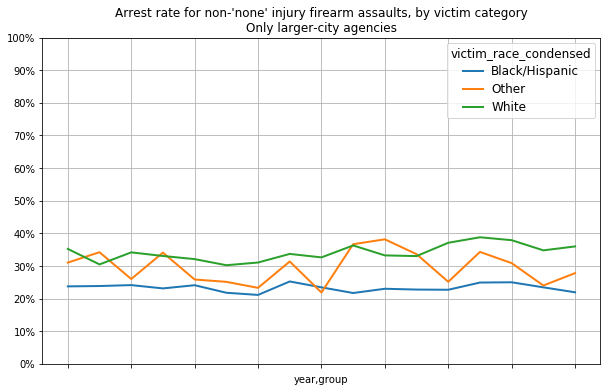

In [47]:
(
    fa_counts_by_injury_and_race
    .loc[lambda df: df["victim_injury_category"] != "none"]
    .loc[lambda df: df["year"] >= 2000]
    .assign(group = "all")
    .pipe(
        calculate_aggregate_disparity,
        grouping = ["year", "group"],
    )
    ["arrest_rate"]
    .pipe(
        plot_rates,
        title = (
            "Arrest rate for non-'none' injury firearm assaults, by victim category\n"
            "Only larger-city agencies"
        )
    )    
)
pass

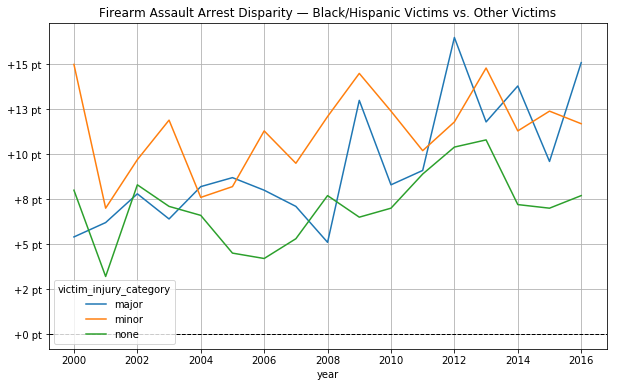

In [48]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.axhline(0, color = "black", linestyle = "--", lw = 1)

(
    fa_counts_by_injury_and_race
    .loc[lambda df: df["year"] >= 2000]
    .pipe(
        calculate_aggregate_disparity,
        grouping = ["year", "victim_injury_category"],
    )
    .reset_index()
    .set_index([ "year", "victim_injury_category" ])
    ["arrest_diff"]
    .unstack()
    .loc[2000:2016]
    .plot(
        ax = ax,
        title = "Firearm Assault Arrest Disparity — Black/Hispanic Victims vs. Other Victims",
    )
)
ax.set_yticklabels([ f"{y * 100:+.0f} pt" for y in ax.get_yticks() ])
ax.grid()
pass

## Calculate median disparities

To avoid too-small sample sizes, all of the calculations below only include agency-level groupings for which there are at least 50 black/Hispanic victims and 50 other victims.

In [49]:
def calculate_agency_disparities(df, grouping, min_victims = 50):
    grouping = grouping if type(grouping) is list else [ grouping ]
    return (        
        df
        .loc[lambda df: df["victim_race_condensed"].isin([
            "Black/Hispanic",
            "White"
        ])]
        .groupby( grouping + [ "agency_ori_9", "victim_race_condensed" ])
        .pipe(lambda grp: pd.DataFrame({
            "num_victims": grp["victims"].sum(),
            "arrest_rate": grp["victims_with_arrest"].sum() / grp["victims"].sum(),
            "clearance_rate": grp["victims_with_clearance"].sum() / grp["victims"].sum(),
        }))
        .loc[lambda df: df["num_victims"] >= min_victims]
        .unstack()
        .dropna()
        .assign(
            arrest_diff = lambda df: (
                df[("arrest_rate", "White")] - 
                df[("arrest_rate", "Black/Hispanic")]
            ).round(3),
            clearance_diff = lambda df: (
                df[("clearance_rate", "White")] - 
                df[("clearance_rate", "Black/Hispanic")]
            ).round(3),
        )
        .reset_index()
    )

In [50]:
def calculate_median_disparity(df, grouping, min_victims = 50):
    grouping = grouping if type(grouping) is list else [ grouping ]
    return (
        calculate_agency_disparities(df, grouping, min_victims)
        .groupby(grouping)
        .pipe(lambda grp: pd.DataFrame({
            "num_agencies": grp.size(),
            "median_arrest_diff": grp["arrest_diff"].median(),
            "median_clearance_diff": grp["clearance_diff"].median(),
        }))
    )

By victim injury category, 2012-2016:

In [51]:
(
    fa_counts_by_injury_and_race
    .loc[lambda df: df["year"] >= 2012]
    .loc[lambda df: df["year"] <= 2016]    
    .pipe(
        calculate_median_disparity,
        grouping = "victim_injury_category",
    )
    .pipe(save, "../../outputs/nibrs-fa-disparities-2012-16-injury-median.csv", index = True)    
)

,num_agencies,median_arrest_diff,median_clearance_diff
victim_injury_category,,,
major,23,0.1340,0.152
minor,18,0.0605,0.074
none,58,0.0345,0.042


For major and minor injuries combined, 2012-2016:

In [52]:
(
    fa_counts_by_injury_and_race
    .loc[lambda df: df["victim_injury_category"] != "none"]
    .loc[lambda df: df["year"] >= 2012]
    .loc[lambda df: df["year"] <= 2016]    
    .assign(group = "major + minor")
    .pipe(
        calculate_median_disparity,
        grouping = "group",
    )
)

,num_agencies,median_arrest_diff,median_clearance_diff
group,,,
major + minor,33,0.088,0.091


For major and minor injuries combined, 2012-2016, by agency population group:

In [53]:
(
    fa_counts_by_injury_and_race
    .loc[lambda df: df["victim_injury_category"] != "none"]
    .loc[lambda df: df["year"] >= 2012]
    .loc[lambda df: df["year"] <= 2016]    
    .pipe(
        calculate_median_disparity,
        grouping = "ori_group_2016",
    )
)

,num_agencies,median_arrest_diff,median_clearance_diff
ori_group_2016,,,
1B,9,0.0810,0.0910
1C,8,0.1000,0.1255
2,16,0.0895,0.0900


In [54]:
(
    victims
    .loc[lambda df: df["top_offense_code"] == "13A"]
    .loc[lambda df: df["victim_injury_category"] != "none"] 
    .loc[lambda df: df["primary_weapon_category"] != "missing"]
    .loc[lambda df: df["year"] >= 2012]
    .loc[lambda df: df["year"] <= 2016]
    .groupby([
        "year",
        "agency_ori_9",
        "ori_group_2016",
        "victim_injury_category",
        "victim_race_condensed",
        "firearm_ind",
    ])
    .pipe(lambda grp: pd.DataFrame({
        "victims": grp.size(),
        "victims_with_arrest": grp["arrest_ind"].sum(),
        "victims_with_clearance": grp["clearance_ind"].sum(),
    }))
    .reset_index()
    .pipe(
        calculate_median_disparity,
        grouping = [ "ori_group_2016", "firearm_ind" ],
    )
)

num_agencies  median_arrest_diff  \
ori_group_2016 firearm_ind                                     
1B             0                      10              0.0180   
               1                       9              0.0810   
1C             0                      11              0.0100   
               1                       8              0.1085   
2              0                      62              0.0345   
               1                      16              0.0935   

                            median_clearance_diff  
ori_group_2016 firearm_ind                         
1B             0                           0.0135  
               1                           0.0930  
1C             0                           0.0130  
               1                           0.1325  
2              0                           0.0395  
               1                           0.0905

# Overall arrest rates, 2012-16, by offense and `firearm_ind`

In [55]:
(
    victims_all
    .loc[lambda df: df["top_offense_code"] == "13A"]
    ["victim_injury_category"]
    .fillna("x")
    .value_counts()
)

none     1640264
minor    1148740
major     908936
Name: victim_injury_category, dtype: int64

In [56]:
(
    victims_all
    .loc[lambda df: ~df["agency_ori_9"].isin(early_nonupdaters.index)]
    .loc[lambda df: df["year"] >= 2012]
    .loc[lambda df: df["year"] <= 2016]
    .loc[lambda df: df["primary_weapon_category"] != "missing"]
    .loc[lambda df: (
        (df["top_offense_code"].isin(["09A", "13A"]))
    )]    
    .drop_duplicates(subset = [ "incident_uid" ])
    .groupby([
        "top_offense_code",
        "larger_city_2016",
        "firearm_ind",
    ])
    ["arrest_ind"]
    .mean()
    .unstack()
    .assign(
        ratio = lambda df: df[1] / df[0]
    )    
    .sort_index(ascending = False)
    .round(3)
)

firearm_ind                            0      1  ratio
top_offense_code larger_city_2016                     
13A              True              0.447  0.249  0.557
                 False             0.573  0.411  0.716
09A              True              0.674  0.420  0.623
                 False             0.680  0.503  0.741

# Calculating days-to-arrest

In this section, we examine trends regarding the amount of time that elapses between offenses and arrests, slicing by offense and weapon type. Similar to the analyses above, we calculate both median rates (metrics first calculated at the agency level) and aggregate rates (metrics calculated on all agencies together).

Here, we select murders and aggravated assaults in 2007–16, in larger-city agencies, excluding incidents for which there is no primary weapon listed, and then calculate the number of days between the incident-occurrence date and the arrest date:

In [57]:
dta_incident_subset = (
    victims
    .loc[lambda df: df["year"] >= 2007]
    .loc[lambda df: df["primary_weapon_category"] != "missing"]
    .loc[lambda df: (
        (df["top_offense_code"].isin(["09A", "13A"]))
    )]    
    .drop_duplicates(subset = [ "incident_uid" ])
    [[
        "incident_uid",
        "year",
        "agency_ori_9",
        "top_offense_code",
        "primary_weapon_category",
        "firearm_ind",
        "arrest_ind",
        "days_to_arrest",
        "arrest_date",
        "occurred_date",
    ]]
    .assign(
        dta_next_day = lambda df: df["days_to_arrest"] <= 1,
        dta_two_weeks = lambda df: (df["days_to_arrest"] > 1) & (df["days_to_arrest"] <= 14),
        dta_30_days = lambda df: (df["days_to_arrest"] > 14) & (df["days_to_arrest"] <= 30),
        dta_later = lambda df: df["days_to_arrest"] > 30,
        dta_never = lambda df: df["days_to_arrest"].isnull(),
    )
)

dta_incident_subset.head()

,incident_uid,year,agency_ori_9,top_offense_code,primary_weapon_category,firearm_ind,arrest_ind,days_to_arrest,arrest_date,occurred_date,dta_next_day,dta_two_weeks,dta_30_days,dta_later,dta_never
2,OHCOP0000|2010|8I0VYC5VT2 N,2010,OHCOP0000,09A,firearm,1,0,NaN,NaT,2010-07-14,False,False,False,False,True
7,AR0600200|2014|2W1Z0UF JNXI,2014,AR0600200,09A,firearm,1,0,NaN,NaT,2014-12-16,False,False,False,False,True
9,AR0600200|2014|2W1Z0UF 8L8I,2014,AR0600200,09A,firearm,1,0,NaN,NaT,2014-12-07,False,False,False,False,True
10,OHCOP0000|2010|8I0VEY3LS2 N,2010,OHCOP0000,09A,firearm,1,1,0.0,2010-07-11,2010-07-11,True,False,False,False,False
11,OHCOP0000|2010|8I0V1WSHF2 N,2010,OHCOP0000,09A,firearm,1,0,NaN,NaT,2010-07-09,False,False,False,False,True


Among larger-city agencies, there are a very small handful of incidents for which the raw data lists an arrestee in the "arrestees segment", but for which the incident-level data says that there are no corresponding arrestees. There is also one incident for which the incident-level data says there's an arrest, but the arrest-level data contains none (and thus no arrest date). For the purposes of the days-to-arrest calculations below, we're using the `arrest_date` (rather than `arrest_ind`) to determine whether there was an arrest, though the effect of this decision is negligible, given the small number of incidents to which it applies.

In [58]:
(
    victims_all
    .loc[lambda df: df["arrest_ind"] == df["arrest_date"].isnull()]
    .loc[lambda df: df["top_offense_code"].isin([ "09A", "13A" ])]
    .loc[lambda df: df["larger_city_2016"] == True]
    .groupby([
        "year",
        "top_offense_code",
        "agency_ori_9"
    ])
    .size()
    .to_frame("arrest_mismatches")
)

arrest_mismatches
year top_offense_code agency_ori_9                   
1991 09A              SC0100100                     1
     13A              SC0100100                     5
                      SC0100800                     2
                      SC0400100                     3
1998 13A              IA0820200                     1
2001 13A              IA0820200                     1
2008 13A              SC0400100                     1
                      TX0430600                     1
2010 13A              TX0201000                     1

In [59]:
(
    victims_all
    .loc[lambda df: df["arrest_ind"] == df["arrest_date"].isnull()]
    .loc[lambda df: df["top_offense_code"].isin([ "09A", "13A" ])]
    .loc[lambda df: df["larger_city_2016"] == True]
    .assign(has_arrest_date = lambda df: df["arrest_date"].notnull())
    .groupby([ "arrest_ind", "has_arrest_date" ])
    .size()
    .to_frame("arrest_mismatches")    
)

,,arrest_mismatches
arrest_ind,has_arrest_date,
0,True,15
1,False,1


In [60]:
assert (dta_incident_subset["days_to_arrest"].min() == 0)

In [61]:
dta_incident_subset["agency_ori_9"].nunique()

94

### Calculate agency-level medians

In [62]:
DTA_CATEGORIES = [    
    "dta_next_day",
    "dta_two_weeks",
    "dta_30_days",
    "dta_later",
    "dta_never",
]

In [63]:
dta_by_agency = (
    dta_incident_subset
    .groupby([
        "agency_ori_9",
        "top_offense_code",
        "firearm_ind",
    ])
    .pipe(lambda grp: pd.DataFrame(dict(
        [ ("num_incidents", grp.size()) ] + [
        (cat, grp[cat].mean().round(3)) for cat in DTA_CATEGORIES
    ])))
    .reset_index()
)
assert((dta_by_agency[DTA_CATEGORIES].sum(axis = 1).round(2) != 1).sum() == 0)
dta_by_agency.head()

,agency_ori_9,top_offense_code,firearm_ind,num_incidents,dta_next_day,dta_two_weeks,dta_30_days,dta_later,dta_never
0,AR0600200,09A,0,47,0.298,0.128,0.000,0.043,0.532
1,AR0600200,09A,1,221,0.109,0.100,0.036,0.081,0.674
2,AR0600200,13A,0,6045,0.154,0.004,0.006,0.015,0.821
3,AR0600200,13A,1,4636,0.067,0.011,0.007,0.013,0.901
4,AZ0071100,09A,0,4,0.750,0.250,0.000,0.000,0.000


In [64]:
(
    dta_by_agency
    # Select only agencies with at least 50 firearm murders 
    # during this timespan
    .loc[lambda df: df["agency_ori_9"].isin(
        df.loc[lambda df: (
            (df["num_incidents"] >= 50) &
            (df["top_offense_code"] == "09A") &
            (df["firearm_ind"] == 1)
        )]
        ["agency_ori_9"]
    )]
    .groupby([
        "top_offense_code",
        "firearm_ind",
    ])
    .pipe(lambda grp: pd.DataFrame(dict(
        [ 
            ("num_agencies", grp.size()),
             ("num_incidents_median", grp["num_incidents"].median()) 
        ] + [
        (cat, grp[cat].median()) for cat in DTA_CATEGORIES
    ])))
    
    .reset_index()
    .pipe(save, "../../outputs/nibrs-days-to-arrest-by-offense-median.csv")
)

,top_offense_code,firearm_ind,num_agencies,num_incidents_median,dta_next_day,dta_two_weeks,dta_30_days,dta_later,dta_never
0,09A,0,41,44,0.385,0.162,0.026,0.077,0.263
1,09A,1,41,133,0.200,0.142,0.036,0.092,0.508
2,13A,0,41,5941,0.350,0.044,0.017,0.038,0.531
3,13A,1,41,1820,0.189,0.038,0.015,0.034,0.723


### Calculate aggregate metrics

In [65]:
dta_aggregates = (
    dta_incident_subset
    .groupby([
        "top_offense_code",
        "firearm_ind",
    ])

    .pipe(lambda grp: pd.DataFrame(dict(
        [ 
            ("num_incidents", grp.size()),
            ("num_agencies", grp["agency_ori_9"].nunique())
        ] + [
        (cat, grp[cat].mean().round(3)) for cat in DTA_CATEGORIES
    ])))
    
    .reset_index()
    .assign(
        index = lambda df: df["firearm_ind"].apply({ 1: "a", 0: "b" }.get) + "-" + df["top_offense_code"]
    )
    .assign(
        label = lambda df: df["index"].apply({
            "a-09A": "Murder - Gun",
            "a-13A": "Aggravated Assault - Gun",
            "b-09A": "Murder - Other Weapon",
            "b-13A": "Aggravated Assault - Other Weapon",
        }.get)
    )       
    .sort_values("index", ascending = False)
    .drop(columns = "index")
    .pipe(save, "../../outputs/nibrs-days-to-arrest-by-offense-aggregate.csv")    
)

dta_aggregates

,top_offense_code,firearm_ind,num_incidents,num_agencies,dta_next_day,dta_two_weeks,dta_30_days,dta_later,dta_never,label
2,13A,0,434711,94,0.350,0.039,0.014,0.032,0.565,Aggravated Assault - Other Weapon
0,09A,0,3543,93,0.408,0.150,0.033,0.087,0.322,Murder - Other Weapon
3,13A,1,176115,94,0.184,0.032,0.011,0.023,0.750,Aggravated Assault - Gun
1,09A,1,11591,91,0.180,0.129,0.033,0.082,0.576,Murder - Gun


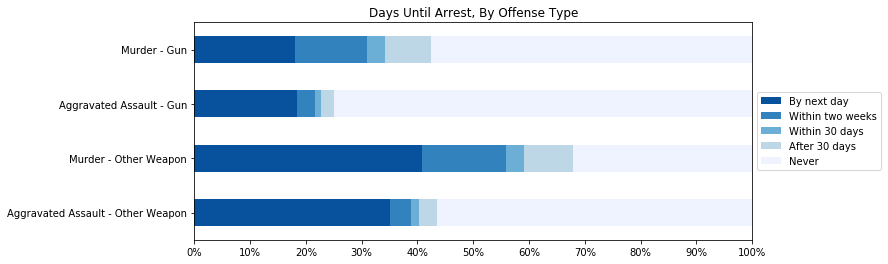

In [66]:
ax = (
    dta_aggregates
    [DTA_CATEGORIES]
    .plot(
        kind = 'barh',
        stacked = True,
        figsize = (10, 4),
        color = [ '#08519c', '#3182bd', '#6baed6', '#bdd7e7', '#eff3ff' ],
        title = "Days Until Arrest, By Offense Type",
    )
)

ax.set_yticklabels(dta_aggregates["label"])

percentify_axes(ax, name = "x")

plt.legend([
    "By next day",
    "Within two weeks",
    "Within 30 days",
    "After 30 days",
    "Never"
], loc='center left', bbox_to_anchor=(1.0, 0.5))

pass

---

---

---